#### **Declare path to project directory**

In [1]:
path_to_directory = "/home/morais/data_science_project"

# **Data Preparation**
## **Methodology**

{'accuracy': [0.1891156462585034, 0.9374149659863945], 'recall': [np.float64(0.975609756097561), np.float64(0.21951219512195122)], 'precision': [np.float64(0.06299212598425197), np.float64(0.391304347826087)], 'auc': [np.float64(0.559130526463766), np.float64(0.5996696422295635)], 'f1': [np.float64(0.11834319526627218), np.float64(0.28125)]}


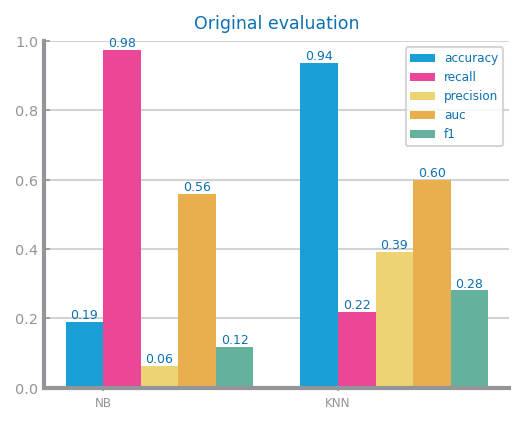

In [2]:
from numpy import ndarray
from pandas import DataFrame, read_csv
from matplotlib.pyplot import savefig, show, figure
from dslabs_functions import plot_multibar_chart, CLASS_EVAL_METRICS, run_KNN
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from dslabs_functions import DELTA_IMPROVE


def run_NB(trnX, trnY, tstX, tstY, metric: str = "accuracy") -> dict[str, float]:
    estimators: dict[str, GaussianNB | BernoulliNB] = {
        "GaussianNB": GaussianNB(),
        "BernoulliNB": BernoulliNB(),
    }
    best_model: GaussianNB | BernoulliNB = None  # type: ignore
    best_performance: float = 0.0
    eval: dict[str, float] = {}

    for clf in estimators:
        estimators[clf].fit(trnX, trnY)
        prdY: ndarray = estimators[clf].predict(tstX)
        performance: float = CLASS_EVAL_METRICS[metric](tstY, prdY)
        if performance - best_performance > DELTA_IMPROVE:
            best_performance = performance
            best_model = estimators[clf]
    if best_model is not None:
        prd: ndarray = best_model.predict(tstX)
        for key in CLASS_EVAL_METRICS:
            eval[key] = CLASS_EVAL_METRICS[key](tstY, prd)
    return eval

def evaluate_approach(
    train: DataFrame, test: DataFrame, target: str = "class", metric: str = "accuracy"
) -> dict[str, list]:
    trnY = train.pop(target).values
    trnX: ndarray = train.values
    tstY = test.pop(target).values
    tstX: ndarray = test.values
    eval: dict[str, list] = {}

    eval_NB: dict[str, float] = run_NB(trnX, trnY, tstX, tstY, metric=metric)
    eval_KNN: dict[str, float] = run_KNN(trnX, trnY, tstX, tstY, metric=metric)
    if eval_NB != {} and eval_KNN != {}:
        for met in CLASS_EVAL_METRICS:
            eval[met] = [eval_NB[met], eval_KNN[met]]
    return eval


target = "CLASS"
file_tag = "class_financial distress"
filename = f"{path_to_directory}/datasets/class_financial distress.csv"
train: DataFrame = read_csv(filepath_or_buffer=filename)

train, test = train_test_split(train, test_size=0.2, random_state=42)

figure()
eval: dict[str, list] = evaluate_approach(train, test, target=target, metric="recall")
print(eval)
plot_multibar_chart(
    ["NB", "KNN"], eval, title="Original evaluation", percentage=True
)
savefig(f"{path_to_directory}/images/Set 2 - Original results.png", bbox_inches='tight')
show()

## **Variable Encoding**
All variables are numeric and the binary one is already in format '0' or '1'.

Methodology results are the same as the previous.

## **Missing Values Imputation**

Dataset nr records=3672 nr variables=87


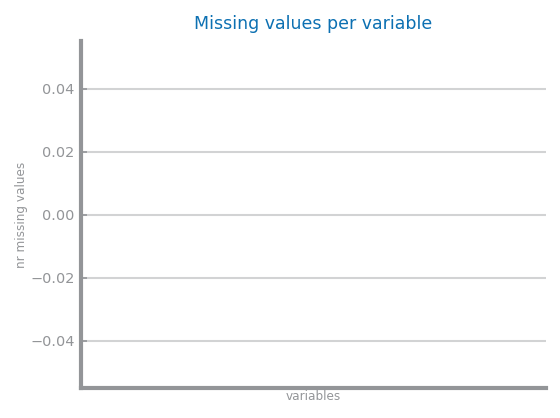

In [3]:
from pandas import read_csv, DataFrame
from matplotlib.pyplot import figure, show
from dslabs_functions import plot_bar_chart

data: DataFrame = read_csv(filepath_or_buffer=filename, na_values="", index_col=None, sep=',', decimal='.')
print(f"Dataset nr records={data.shape[0]}", f"nr variables={data.shape[1]}")

mv: dict[str, int] = {}
figure()
for var in data:
    nr: int = data[var].isna().sum()
    if nr > 0:
        mv[var] = nr

plot_bar_chart(
    list(mv.keys()),
    list(mv.values()),
    title="Missing values per variable",
    xlabel="variables",
    ylabel="nr missing values",
)
show()

No further need to deal with missing values because there are no missing values

Methodology results are the same as the previous.
## **Outliers**
### Dropping Outliers

In [4]:
from pandas import read_csv, DataFrame, Series
from dslabs_functions import (
    NR_STDEV,
    get_variable_types,
    determine_outlier_thresholds_for_var,
)

data: DataFrame = read_csv(filepath_or_buffer=filename, na_values="", index_col=None, sep=',', decimal='.')
print(f"Original data: {data.shape}")

n_std: int = NR_STDEV
n_std = 9
print("n_std=", n_std)

numeric_vars: list[str] = get_variable_types(data)["numeric"]
if numeric_vars is not None:
    df: DataFrame = data.copy(deep=True)
    summary5: DataFrame = data[numeric_vars].describe()
    for var in numeric_vars:
        top_threshold, bottom_threshold = determine_outlier_thresholds_for_var(
            summary5[var], threshold= n_std
        )
        outliers: Series = df[(df[var] > top_threshold) | (df[var] < bottom_threshold)]
        df.drop(outliers.index, axis=0, inplace=True)
    df.to_csv(f"{path_to_directory}/datasets/{file_tag}_drop_outliers.csv", index=False)
    print(f"Data after dropping outliers: {df.shape}")
else:
    print("There are no numeric variables")

Original data: (3672, 87)
n_std= 9
Data after dropping outliers: (3577, 87)


Methodology

{'accuracy': [0.20251396648044692, 0.952513966480447], 'recall': [np.float64(1.0), np.float64(0.2692307692307692)], 'precision': [np.float64(0.04355108877721943), np.float64(0.3181818181818182)], 'auc': [np.float64(0.586231884057971), np.float64(0.6237458193979932)], 'f1': [np.float64(0.08346709470304976), np.float64(0.2916666666666667)]}


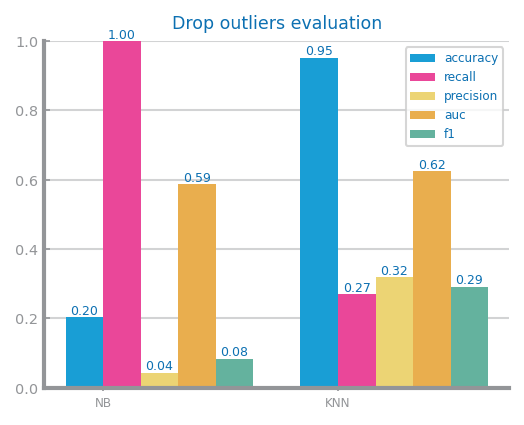

In [5]:
train: DataFrame = read_csv(f"{path_to_directory}/datasets/{file_tag}_drop_outliers.csv")

train, test = train_test_split(train, test_size=0.2, random_state=42)

figure()
eval_dropping: dict[str, list] = evaluate_approach(train, test, target=target, metric="recall")
print(eval_dropping)
plot_multibar_chart(
    ["NB", "KNN"], eval_dropping, title="Drop outliers evaluation", percentage=True
)
savefig(f"{path_to_directory}/images/Set 2 - Outliers first approach (drop) results.png", bbox_inches='tight')
show()

### Replacing outliers with fixed value


In [6]:
if [] != numeric_vars:
    df: DataFrame = data.copy(deep=True)
    for var in numeric_vars:
        top, bottom = determine_outlier_thresholds_for_var(summary5[var])
        median: float = df[var].median()
        df[var] = df[var].apply(lambda x: median if x > top or x < bottom else x)
    df.to_csv(f"{path_to_directory}/datasets/{file_tag}_replacing_outliers.csv", index=False)
    print("Data after replacing outliers:", df.shape)
    print(df.describe())
else:
    print("There are no numeric variables")

Data after replacing outliers: (3672, 87)
           Company         Time  Financial Distress        CLASS           x1  \
count  3672.000000  3672.000000         3672.000000  3672.000000  3672.000000   
mean    180.299292     7.528322            0.882825     0.037037     1.286091   
std     115.289514     4.064016            1.201236     0.188878     0.579206   
min       1.000000     1.000000           -4.063300     0.000000     0.075170   
25%      80.000000     4.000000            0.174423     0.000000     0.952145   
50%     168.000000     7.000000            0.583805     0.000000     1.183550   
75%     262.000000    11.000000            1.278950     0.000000     1.479075   
max     416.000000    14.000000            6.312400     1.000000     4.289400   

                x2           x3            x4           x5           x6  ...  \
count  3672.000000  3672.000000  3.672000e+03  3672.000000  3672.000000  ...   
mean      0.115923     0.632942  7.944232e-01     0.140659     0.101

Methodology

{'accuracy': [0.17006802721088435, 0.9360544217687075], 'recall': [np.float64(0.9512195121951219), np.float64(0.1951219512195122)], 'precision': [np.float64(0.06027820710973725), np.float64(0.36363636363636365)], 'auc': [np.float64(0.5375694102762353), np.float64(0.5874745202783439)], 'f1': [np.float64(0.11337209302325581), np.float64(0.25396825396825395)]}


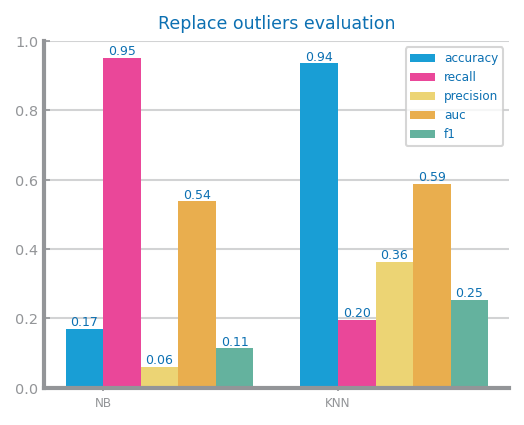

In [7]:
train: DataFrame = read_csv(f"{path_to_directory}/datasets/{file_tag}_replacing_outliers.csv")

train, test = train_test_split(train, test_size=0.2, random_state=42)

figure()
eval_replacing: dict[str, list] = evaluate_approach(train, test, target=target, metric="recall")
print(eval_replacing)
plot_multibar_chart(
    ["NB", "KNN"], eval_replacing, title="Replace outliers evaluation", percentage=True
)
savefig(f"{path_to_directory}/images/Set 2 - Outliers second approach (replacing) results.png", bbox_inches='tight')
show()

### Truncating outliers


In [8]:
if [] != numeric_vars:
    df: DataFrame = data.copy(deep=True)
    for var in numeric_vars:
        top, bottom = determine_outlier_thresholds_for_var(summary5[var])
        df[var] = df[var].apply(
            lambda x: top if x > top else bottom if x < bottom else x
        )
    df.to_csv(f"{path_to_directory}/datasets/{file_tag}_truncate_outliers.csv", index=False)
    print("Data after truncating outliers:", df.shape)
    print(df.describe())
else:
    print("There are no numeric variables")

Data after truncating outliers: (3672, 87)
           Company         Time  Financial Distress        CLASS           x1  \
count  3672.000000  3672.000000         3672.000000  3672.000000  3672.000000   
mean    182.056230     7.528322            0.968539     0.037037     1.330980   
std     116.967639     4.064016            1.390794     0.188878     0.681107   
min       1.000000     1.000000           -4.264198     0.000000     0.075170   
25%      80.000000     4.000000            0.172275     0.000000     0.952145   
50%     168.000000     7.000000            0.583805     0.000000     1.183600   
75%     264.250000    11.000000            1.351750     0.000000     1.506475   
max     416.133694    14.000000            6.344711     1.000000     4.293672   

                x2           x3            x4           x5           x6  ...  \
count  3672.000000  3672.000000  3.672000e+03  3672.000000  3672.000000  ...   
mean      0.126114     0.618399  8.371999e-01     0.151653     0.10

Methodology

{'accuracy': [0.2680272108843537, 0.9374149659863945], 'recall': [np.float64(0.9024390243902439), np.float64(0.21951219512195122)], 'precision': [np.float64(0.0647985989492119), np.float64(0.391304347826087)], 'auc': [np.float64(0.5664932874112603), np.float64(0.5996696422295635)], 'f1': [np.float64(0.12091503267973856), np.float64(0.28125)]}


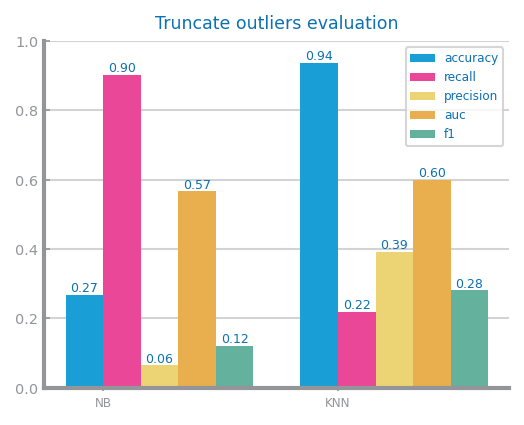

In [9]:
train: DataFrame = read_csv(f"{path_to_directory}/datasets/{file_tag}_truncate_outliers.csv")

train, test = train_test_split(train, test_size=0.2, random_state=42)

figure()
eval_truncate: dict[str, list] = evaluate_approach(train, test, target=target, metric="recall")
print(eval_truncate)
plot_multibar_chart(
    ["NB", "KNN"], eval_truncate, title="Truncate outliers evaluation", percentage=True
)
savefig(f"{path_to_directory}/images/Set 2 - Outliers third approach (truncate) results.png", bbox_inches='tight')
show()

### Outlier method evaluation

In [10]:
# # Combine all evaluations into a list
# evaluations = {"original": eval, "drop": eval_dropping, "replacing": eval_replacing, "truncate": eval_truncate}

# # Variables to track the best recalls
# best_recall_NB = -float("inf")
# best_recall_KNN = -float("inf")
# best_eval_NB = None
# best_eval_KNN = None

# # Iterate through evaluations and print recalls
# for eval_name, eval_dict in evaluations.items():
#     recall_NB = eval_dict["recall"][0]  # First index for NB
#     recall_KNN = eval_dict["recall"][1]  # Second index for KNN
#     print(f"{eval_name}: NB Recall = {recall_NB}, KNN Recall = {recall_KNN}")

#     # Update the best recall for NB
#     if recall_NB > best_recall_NB:
#         best_recall_NB = recall_NB
#         best_eval_NB = eval_name

#     # Update the best recall for KNN
#     if recall_KNN > best_recall_KNN:
#         best_recall_KNN = recall_KNN
#         best_eval_KNN = eval_name

# # Print the best recalls
# print(f"\nBest NB Recall: {best_recall_NB} from {best_eval_NB}")
# print(f"Best KNN Recall: {best_recall_KNN} from {best_eval_KNN}")

# if best_eval_NB == "original" and best_eval_KNN == "original":
#     filename = f"/home/morais/data_science_project/datasets/{file_tag}.csv"
# elif best_eval_NB == "dropping" and best_eval_KNN == "dropping":
#     filename = f"/home/morais/data_science_project/datasets/{file_tag}_drop_outliers.csv"
# elif best_eval_NB == "replacing" and best_eval_KNN == "replacing":
#     filename = f"/home/morais/data_science_project/datasets/{file_tag}_replacing_outliers.csv"
# elif best_eval_NB == "truncate" and best_eval_KNN == "truncate":
#     filename = f"/home/morais/data_science_project/datasets/{file_tag}_truncate_outliers.csv"

In [11]:
evaluations = {"original": eval, "drop": eval_dropping, "replacing": eval_replacing, "truncate": eval_truncate}

best_mean = -float("inf")
best_mean_NB = -float("inf")
best_mean_KNN = -float("inf")
best_eval = None
best_eval_NB = None
best_eval_KNN = None
best_eval_dict = None

for eval_name, eval_dict in evaluations.items():
    # Calculate mean for NB and KNN using generator expressions
    mean_NB = sum(eval_dict[metric][0] for metric in ["accuracy", "recall", "precision", "auc", "f1"]) / 5
    mean_KNN = sum(eval_dict[metric][1] for metric in ["accuracy", "recall", "precision", "auc", "f1"]) / 5
    
    # Print means
    print(f"{eval_name}: Mean NB = {mean_NB}, Mean KNN = {mean_KNN}")

    # Update the best mean for NB
    if mean_NB > best_mean_NB:
        best_mean_NB = mean_NB
        best_eval_NB = eval_name

    # Update the best mean for KNN
    if mean_KNN > best_mean_KNN:
        best_mean_KNN = mean_KNN
        best_eval_KNN = eval_name

# Print the best mean scores
print(f"\nBest Mean NB: {best_mean_NB} from {best_eval_NB}")
print(f"Best Mean KNN: {best_mean_KNN} from {best_eval_KNN}")

if best_mean_NB > best_mean_KNN:
    best_mean = best_mean_NB
    best_eval = best_eval_NB
else:
    best_mean = best_mean_KNN
    best_eval = best_eval_KNN

print(f"\nContinuing with {best_eval} with mean {best_mean}")

# Determine the filename based on the best evaluations
if best_eval == "original":
    filename = f"{path_to_directory}/datasets/{file_tag}.csv"
    best_eval_dict = eval
elif best_eval == "drop":
    filename = f"{path_to_directory}/datasets/{file_tag}_drop_outliers.csv"
    best_eval_dict = eval_dropping
elif best_eval == "replacing":
    filename = f"{path_to_directory}/datasets/{file_tag}_replacing_outliers.csv"
    best_eval_dict = eval_replacing
elif best_eval == "truncate":
    filename = f"{path_to_directory}/datasets/{file_tag}_truncate_outliers.csv"
    best_eval_dict = eval_truncate

original: Mean NB = 0.3810382500140709, Mean KNN = 0.4858302302327992
drop: Mean NB = 0.3831528068037374, Mean KNN = 0.4910678079915388
replacing: Mean NB = 0.3665014499630469, Mean KNN = 0.46725110217423615
truncate: Mean NB = 0.3845346308629617, Mean KNN = 0.4858302302327992

Best Mean NB: 0.3845346308629617 from truncate
Best Mean KNN: 0.4910678079915388 from drop

Continuing with drop with mean 0.4910678079915388


## **Scaling**
### Standard Scaler

In [12]:
from pandas import read_csv, DataFrame, Series
from sklearn.preprocessing import StandardScaler


# Load the dataset
data: DataFrame = read_csv(filename)
target = "CLASS"

# Separate the target column
target_data: Series = data.pop(target).copy()  # Use .copy() to ensure immutability

# Scale only the feature variables
scaler = StandardScaler(with_mean=True, with_std=True, copy=True)
scaled_features = scaler.fit_transform(data)

# Create a DataFrame for the scaled data
df_zscore = DataFrame(scaled_features, columns=data.columns, index=data.index)

# Insert the target variable at the 4th index (Python index 3)
df_zscore.insert(3, target, target_data)

# Save the final DataFrame
df_zscore.to_csv(f"{path_to_directory}/datasets/{file_tag}_scaled_zscore.csv", index=False)

#### KNN results

{'accuracy': [0.9567039106145251], 'recall': [np.float64(0.3076923076923077)], 'precision': [np.float64(0.38095238095238093)], 'auc': [np.float64(0.6444258639910813)], 'f1': [np.float64(0.3404255319148936)]}


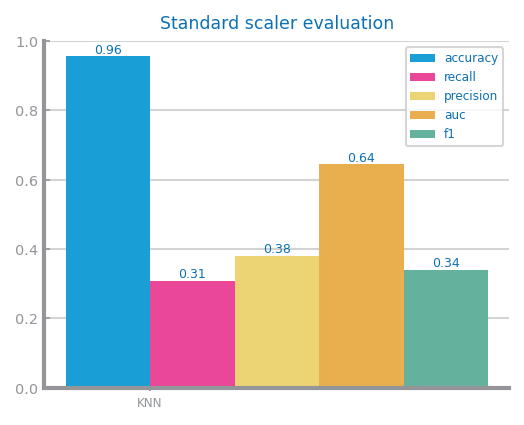

In [13]:
def evaluate_approach(
    train: DataFrame, test: DataFrame, target: str = "class", metric: str = "accuracy"
) -> dict[str, list]:
    # Separate features and target variables
    trnY = train.pop(target).values
    trnX: ndarray = train.values
    tstY = test.pop(target).values
    tstX: ndarray = test.values

    # Evaluate KNN
    eval_KNN: dict[str, float] = run_KNN(trnX, trnY, tstX, tstY, metric=metric)
    
    # Create evaluation dictionary
    eval: dict[str, list] = {}
    for met in CLASS_EVAL_METRICS:
        eval[met] = [eval_KNN[met]]  # Only store KNN results as a single-entry list

    return eval


train, test = train_test_split(df_zscore, test_size=0.2, random_state=42)

figure()
eval_zscore: dict[str, list] = evaluate_approach(train, test, target=target, metric="recall")
print(eval_zscore)
plot_multibar_chart(
    ["KNN"], eval_zscore, title="Standard scaler evaluation", percentage=True
)
savefig(f"{path_to_directory}/images/Set 2 - z-score: KNN results.png", bbox_inches='tight')
show()

### MinMax Scaler


In [14]:
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame, Series, read_csv

# Load data
data: DataFrame = read_csv(filename)
target = "CLASS"
vars: list[str] = data.columns.to_list()

# Separate target column
target_data: Series = data.pop(target)

# Apply MinMaxScaler to the remaining columns
transf: MinMaxScaler = MinMaxScaler(feature_range=(0, 1), copy=True).fit(data)
df_minmax = DataFrame(transf.transform(data), index=data.index, columns=data.columns)

# Reinsert the target column at the 4th index
df_minmax.insert(3, target, target_data)

# Rename columns to match original variable names
df_minmax.columns = vars

# Save the resulting DataFrame
df_minmax.to_csv(f"{path_to_directory}/datasets/{file_tag}_scaled_minmax.csv", index=False)

#### KNN results

{'accuracy': [0.9594972067039106], 'recall': [np.float64(0.23076923076923078)], 'precision': [np.float64(0.4)], 'auc': [np.float64(0.6088628762541806)], 'f1': [np.float64(0.2926829268292683)]}


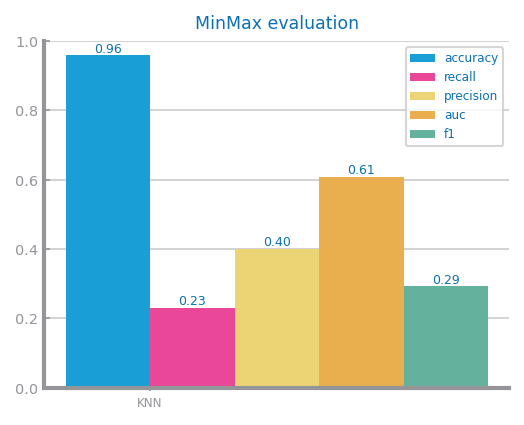

In [15]:
train, test = train_test_split(df_minmax, test_size=0.2, random_state=42)

figure()
eval_minmax: dict[str, list] = evaluate_approach(train, test, target=target, metric="recall")
print(eval_minmax)
plot_multibar_chart(
    ["KNN"], eval_minmax, title="MinMax evaluation", percentage=True
)
savefig(f"{path_to_directory}/images/Set 2 - min-max: KNN results.png", bbox_inches='tight')
show()

### Transformed data in boxplot

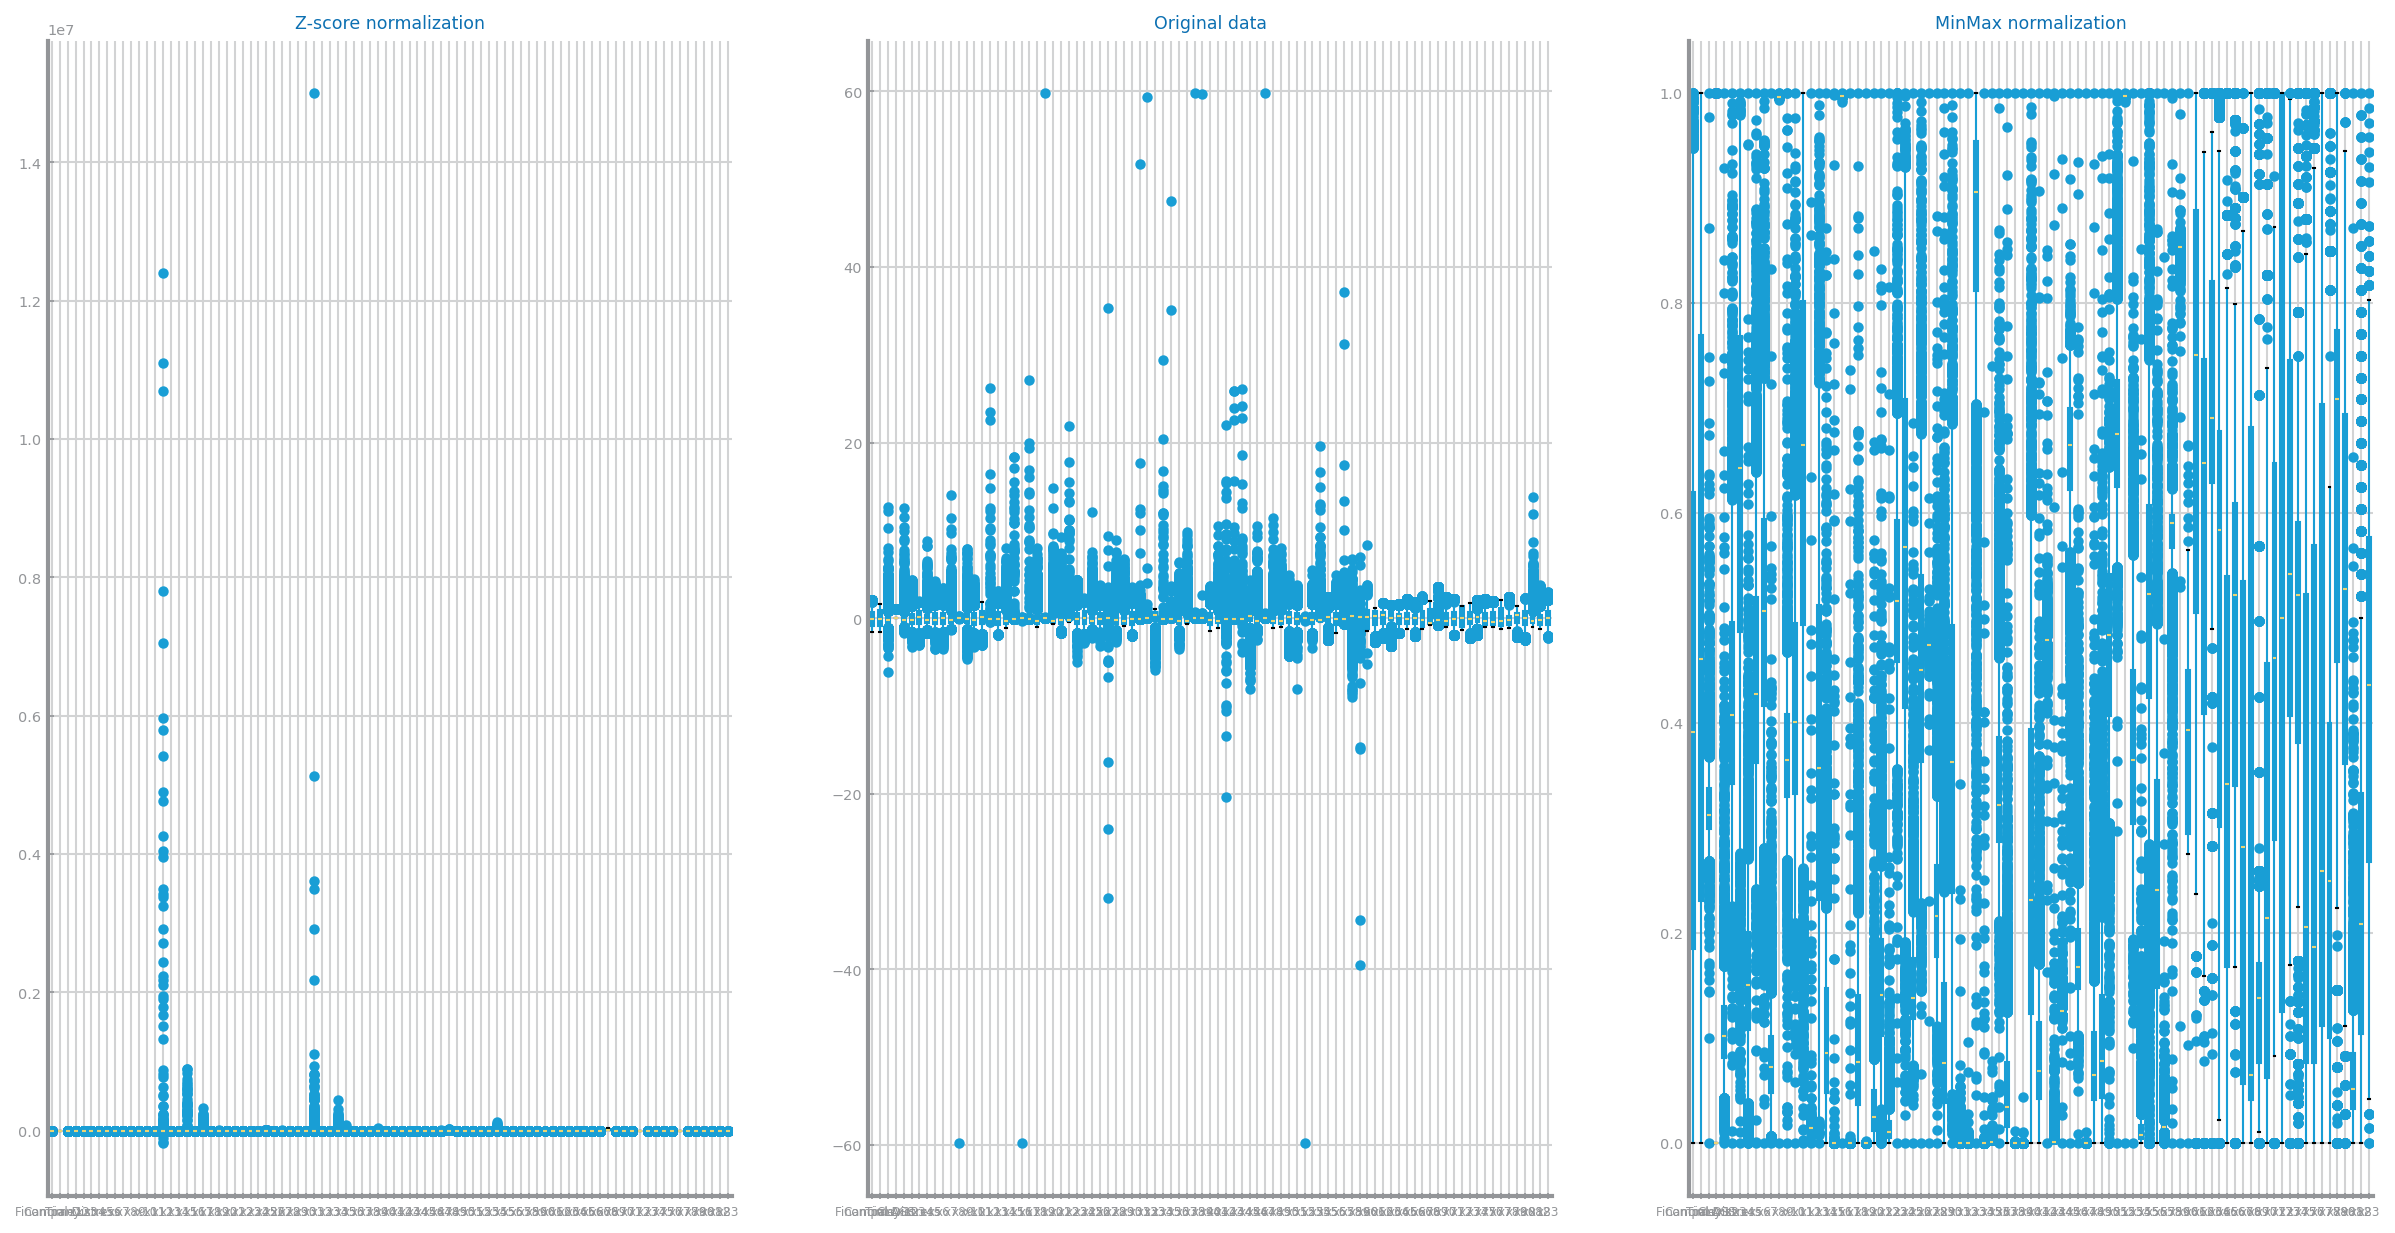

In [16]:
from matplotlib.pyplot import subplots, show

fig, axs = subplots(1, 3, figsize=(20, 10), squeeze=False)
axs[0, 1].set_title("Original data")
data.boxplot(ax=axs[0, 0])
axs[0, 0].set_title("Z-score normalization")
df_zscore.boxplot(ax=axs[0, 1])
axs[0, 2].set_title("MinMax normalization")
df_minmax.boxplot(ax=axs[0, 2])
show()

### Scaling method evaluation

In [17]:
print(f"Continuing from {best_eval} with mean {best_mean}\n")

evaluations = {f"{best_eval}": best_eval_dict, "standard_scaler": eval_zscore, "minmax": eval_minmax}

aux_best_eval = best_eval
best_mean = -float("inf")
mean = -float("inf")
best_eval = None

for eval_name, eval_dict in evaluations.items():
    if eval_name == "drop":
        mean = sum(eval_dict[metric][1] for metric in ["accuracy", "recall", "precision", "auc", "f1"]) / 5
    else:
        mean = sum(eval_dict[metric][0] for metric in ["accuracy", "recall", "precision", "auc", "f1"]) / 5
    
    # Print means
    print(f"{eval_name}: Mean = {mean}")

    # Update the best mean
    if mean > best_mean:
        best_mean = mean
        best_eval = eval_name

# Print the best mean scores
print(f"\nContinuing with {best_eval} with mean {best_mean}")

# Determine the filename based on the best evaluations
if best_eval == f"{aux_best_eval}":
    filename = f"{path_to_directory}/datasets/{file_tag}.csv"
    best_eval_dict = best_eval_dict
elif best_eval == "standard_scaler":
    filename = f"{path_to_directory}/datasets/{file_tag}_scaled_zscore.csv"
    best_eval_dict = eval_zscore
elif best_eval == "minmax":
    filename = f"{path_to_directory}/datasets/{file_tag}_scaled_minmax.csv"
    best_eval_dict = eval_minmax

Continuing from drop with mean 0.4910678079915388

drop: Mean = 0.4910678079915388
standard_scaler: Mean = 0.5260399990330378
minmax: Mean = 0.498362448111318

Continuing with standard_scaler with mean 0.5260399990330378


# **Feature Engineering**
## **Feature Selection**
### Dropping Low Variance Variables


In [18]:
from pandas import DataFrame, Index, read_csv
from dslabs_functions import (
    select_low_variance_variables,
    study_variance_for_feature_selection,
    apply_feature_selection,
    select_redundant_variables,
    study_redundancy_for_feature_selection,
)


def select_low_variance_variables(
    data: DataFrame, max_threshold: float, target: str = "class"
) -> list:
    summary5: DataFrame = data.describe()
    vars2drop: Index[str] = summary5.columns[
        summary5.loc["std"] * summary5.loc["std"] < max_threshold
    ]
    vars2drop = vars2drop.drop(target) if target in vars2drop else vars2drop
    return list(vars2drop.values)


target = "CLASS"
train: DataFrame = read_csv(filepath_or_buffer=filename)

print("Original variables", train.columns.to_list())
vars2drop: list[str] = select_low_variance_variables(train, 3, target=target)
print("Variables to drop", vars2drop)

Original variables ['Company', 'Time', 'Financial Distress', 'CLASS', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29', 'x30', 'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38', 'x39', 'x40', 'x41', 'x42', 'x43', 'x44', 'x45', 'x46', 'x47', 'x48', 'x49', 'x50', 'x51', 'x52', 'x53', 'x54', 'x55', 'x56', 'x57', 'x58', 'x59', 'x60', 'x61', 'x62', 'x63', 'x64', 'x65', 'x66', 'x67', 'x68', 'x69', 'x70', 'x71', 'x72', 'x73', 'x74', 'x75', 'x76', 'x77', 'x78', 'x79', 'x80', 'x81', 'x82', 'x83']
Variables to drop ['Company', 'Time', 'Financial Distress', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29', 'x30', 'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38', 'x39', 'x40', 'x41', 'x42', 'x43', 'x44',

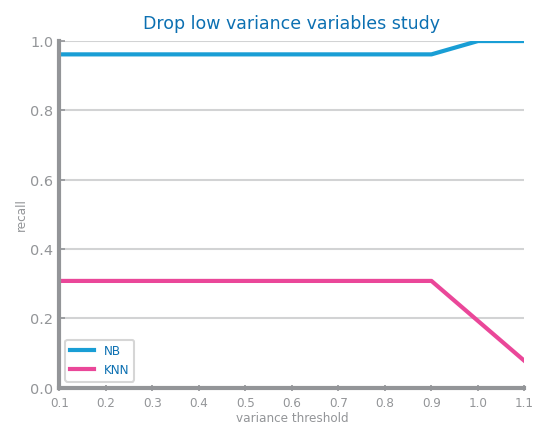

In [19]:
from math import ceil
from matplotlib.pyplot import savefig, show, figure
from dslabs_functions import HEIGHT, plot_multiline_chart
from pandas import Index


def evaluate_approach(
    train: DataFrame, test: DataFrame, target: str = "class", metric: str = "accuracy"
) -> dict[str, list]:
    trnY = train.pop(target).values
    trnX: ndarray = train.values
    tstY = test.pop(target).values
    tstX: ndarray = test.values
    eval: dict[str, list] = {}

    eval_NB: dict[str, float] = run_NB(trnX, trnY, tstX, tstY, metric=metric)
    eval_KNN: dict[str, float] = run_KNN(trnX, trnY, tstX, tstY, metric=metric)
    if eval_NB != {} and eval_KNN != {}:
        for met in CLASS_EVAL_METRICS:
            eval[met] = [eval_NB[met], eval_KNN[met]]
    return eval

def study_variance_for_feature_selection(
    train: DataFrame,
    test: DataFrame,
    target: str = "class",
    max_threshold: float = 1,
    lag: float = 0.05,
    metric: str = "accuracy",
    file_tag: str = "",
) -> dict:
    options: list[float] = [
        round(i * lag, 3) for i in range(1, ceil(max_threshold / lag + lag))
    ]
    results: dict[str, list] = {"NB": [], "KNN": []}
    summary5: DataFrame = train.describe()
    for thresh in options:
        vars2drop: Index[str] = summary5.columns[
            summary5.loc["std"] * summary5.loc["std"] < thresh
        ]
        vars2drop = vars2drop.drop(target) if target in vars2drop else vars2drop

        train_copy: DataFrame = train.drop(vars2drop, axis=1, inplace=False)
        test_copy: DataFrame = test.drop(vars2drop, axis=1, inplace=False)
        eval: dict[str, list] | None = evaluate_approach(
            train_copy, test_copy, target=target, metric=metric
        )
        if eval is not None:
            results["NB"].append(eval[metric][0])
            results["KNN"].append(eval[metric][1])

    plot_multiline_chart(
        options,
        results,
        title=f"Drop low variance variables study",
        xlabel="variance threshold",
        ylabel=metric,
        percentage=True,
    )
    savefig(f"{path_to_directory}/images/Set 2 - Drop low variance variables study.png", bbox_inches='tight')
    return results

target = "CLASS"
train: DataFrame = read_csv(filepath_or_buffer=filename)

eval_metric = "recall"
train, test = train_test_split(train, test_size=0.2, random_state=42)

# figure(figsize=(2 * HEIGHT, HEIGHT))
figure()
study_variance_for_feature_selection(
    train,
    test,
    target=target,
    max_threshold=1.1,
    lag=0.1,
    metric=eval_metric,
    file_tag=file_tag,
)
show()

In [20]:
def apply_feature_selection(
    train: DataFrame,
    test: DataFrame,
    vars2drop: list,
    filename: str = "",
    tag: str = "",
) -> tuple[DataFrame, DataFrame]:
    train_copy: DataFrame = train.drop(vars2drop, axis=1, inplace=False)
    train_copy.to_csv(f"{filename}_train_{tag}.csv", index=False)
    test_copy: DataFrame = test.drop(vars2drop, axis=1, inplace=False)
    test_copy.to_csv(f"{filename}_test_{tag}.csv", index=False)
    return train_copy, test_copy


vars2drop: list[str] = select_low_variance_variables(
    train, max_threshold=0.9, target=target
)
train_cp, test_cp = apply_feature_selection(
    train, test, vars2drop, filename=f"{path_to_directory}/datasets/{file_tag}", tag="lowvar"
)
print(f"Original data: train={train.shape}, test={test.shape}")
print(f"After low variance FS: train_cp={train_cp.shape}, test_cp={test_cp.shape}")

Original data: train=(2861, 87), test=(716, 87)
After low variance FS: train_cp=(2861, 78), test_cp=(716, 78)


Methodology

{'accuracy': [0.6270949720670391, 0.9581005586592178], 'recall': [np.float64(0.9615384615384616), np.float64(0.3076923076923077)], 'precision': [np.float64(0.0859106529209622), np.float64(0.4)], 'auc': [np.float64(0.7880156075808249), np.float64(0.6451505016722408)], 'f1': [np.float64(0.15772870662460567), np.float64(0.34782608695652173)]}


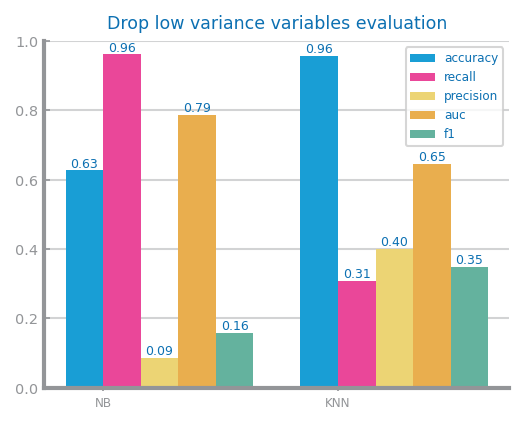

In [21]:
figure()
eval_lowvar: dict[str, list] = evaluate_approach(train_cp, test_cp, target=target, metric="recall")
print(eval_lowvar)
plot_multibar_chart(
    ["NB", "KNN"], eval_lowvar, title="Drop low variance variables evaluation", percentage=True
)
savefig(f"{path_to_directory}/images/Set 2 - Drop low variance variables results.png", bbox_inches='tight')
show()

### Dropping Redundant Variables


In [22]:
from pandas import Series


def select_redundant_variables(
    data: DataFrame, min_threshold: float = 0.90, target: str = "class"
) -> list:
    df: DataFrame = data.drop(target, axis=1, inplace=False)
    corr_matrix: DataFrame = abs(df.corr())
    variables: Index[str] = corr_matrix.columns
    vars2drop: list = []
    for v1 in variables:
        vars_corr: Series = (corr_matrix[v1]).loc[corr_matrix[v1] >= min_threshold]
        vars_corr.drop(v1, inplace=True)
        if len(vars_corr) > 1:
            lst_corr = list(vars_corr.index)
            for v2 in lst_corr:
                if v2 not in vars2drop:
                    vars2drop.append(v2)
    return vars2drop


print("Original variables", train.columns.values)
vars2drop: list[str] = select_redundant_variables(
    train, target=target, min_threshold=0.5
)
print("Variables to drop", vars2drop)

Original variables ['Company' 'Time' 'Financial Distress' 'CLASS' 'x1' 'x2' 'x3' 'x4' 'x5'
 'x6' 'x7' 'x8' 'x9' 'x10' 'x11' 'x12' 'x13' 'x14' 'x15' 'x16' 'x17' 'x18'
 'x19' 'x20' 'x21' 'x22' 'x23' 'x24' 'x25' 'x26' 'x27' 'x28' 'x29' 'x30'
 'x31' 'x32' 'x33' 'x34' 'x35' 'x36' 'x37' 'x38' 'x39' 'x40' 'x41' 'x42'
 'x43' 'x44' 'x45' 'x46' 'x47' 'x48' 'x49' 'x50' 'x51' 'x52' 'x53' 'x54'
 'x55' 'x56' 'x57' 'x58' 'x59' 'x60' 'x61' 'x62' 'x63' 'x64' 'x65' 'x66'
 'x67' 'x68' 'x69' 'x70' 'x71' 'x72' 'x73' 'x74' 'x75' 'x76' 'x77' 'x78'
 'x79' 'x80' 'x81' 'x82' 'x83']
Variables to drop ['x61', 'x62', 'x64', 'x68', 'x73', 'x75', 'x76', 'x77', 'x10', 'x25', 'x48', 'x81', 'x3', 'x6', 'x7', 'x13', 'x24', 'x45', 'x46', 'x5', 'x9', 'x23', 'x36', 'x50', 'x53', 'x1', 'x2', 'x14', 'x41', 'x49', 'x21', 'x11', 'x30', 'x32', 'x35', 'x38', 'x59', 'Financial Distress', 'x33', 'x40', 'x56', 'x47', 'x52', 'x43', 'x44', 'x37', 'x8', 'x16', 'x29', 'x4', 'x22', 'Time', 'x63', 'x70', 'x71', 'x72', 'x79', 'x78', 'x74'

Skipping threshold 0.3 due to empty evaluation results.
Skipping threshold 0.35 due to empty evaluation results.


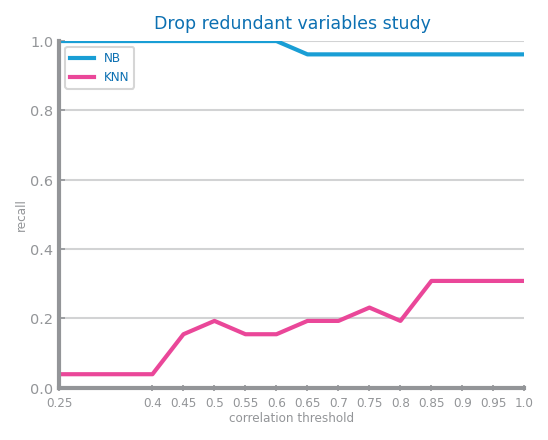

In [23]:
def study_redundancy_for_feature_selection(
    train: DataFrame,
    test: DataFrame,
    target: str = "class",
    min_threshold: float = 0.90,
    lag: float = 0.05,
    metric: str = "accuracy",
    file_tag: str = "",
) -> dict:
    options: list[float] = [
        round(min_threshold + i * lag, 3)
        for i in range(ceil((1 - min_threshold) / lag) + 1)
    ]

    # Create a list to track valid thresholds
    valid_thresholds = []

    df: DataFrame = train.drop(target, axis=1, inplace=False)
    corr_matrix: DataFrame = abs(df.corr())
    variables: Index[str] = corr_matrix.columns
    results: dict[str, list] = {"NB": [], "KNN": []}
    for thresh in options:
        vars2drop: list = []
        for v1 in variables:
            vars_corr: Series = (corr_matrix[v1]).loc[corr_matrix[v1] >= thresh]
            vars_corr.drop(v1, inplace=True)
            if len(vars_corr) > 1:
                lst_corr = list(vars_corr.index)
                for v2 in lst_corr:
                    if v2 not in vars2drop:
                        vars2drop.append(v2)

        train_copy: DataFrame = train.drop(vars2drop, axis=1, inplace=False)
        test_copy: DataFrame = test.drop(vars2drop, axis=1, inplace=False)
        eval: dict | None = evaluate_approach(
            train_copy, test_copy, target=target, metric=metric
        )
        # print(f"Evaluation results for threshold: {thresh} => {eval}")
        # if eval is not None:
        #     results["NB"].append(eval[metric][0])
        #     results["KNN"].append(eval[metric][1])
        if eval:  # Check if eval is not empty
            valid_thresholds.append(thresh)
            results["NB"].append(eval[metric][0])
            results["KNN"].append(eval[metric][1])
        else:
            print(f"Skipping threshold {thresh} due to empty evaluation results.")

    plot_multiline_chart(
        # options,
        valid_thresholds,
        results,
        title=f"Drop redundant variables study",
        xlabel="correlation threshold",
        ylabel=metric,
        percentage=True,
    )
    savefig(f"{path_to_directory}/images/Set 2 - Drop redundant variables study.png", bbox_inches='tight')
    return results


target = "CLASS"
train: DataFrame = read_csv(filepath_or_buffer=filename)

eval_metric = "recall"
train, test = train_test_split(train, test_size=0.2, random_state=42)

# figure(figsize=(2 * HEIGHT, HEIGHT))
figure()
study_redundancy_for_feature_selection(
    train,
    test,
    target=target,
    min_threshold=0.25,
    lag=0.05,
    metric=eval_metric,
    file_tag=file_tag,
)
show()

Performance of NB practically does not change. For KNN it increases for >0.8.

In [24]:
vars2drop: list[str] = select_redundant_variables(
    train, min_threshold=0.8, target=target
)
train_cp, test_cp = apply_feature_selection(
    train, test, vars2drop, filename=f"{path_to_directory}/datasets/{file_tag}", tag="redundant"
)
print(f"Original data: train={train.shape}, test={test.shape}")
print(f"After redundant FS: train_cp={train_cp.shape}, test_cp={test_cp.shape}")

Original data: train=(2861, 87), test=(716, 87)
After redundant FS: train_cp=(2861, 60), test_cp=(716, 60)


Methodology

{'accuracy': [0.3393854748603352, 0.9594972067039106], 'recall': [np.float64(0.9615384615384616), np.float64(0.19230769230769232)], 'precision': [np.float64(0.05030181086519115), np.float64(0.38461538461538464)], 'auc': [np.float64(0.6387402452619845), np.float64(0.5903567447045708)], 'f1': [np.float64(0.09560229445506692), np.float64(0.2564102564102564)]}


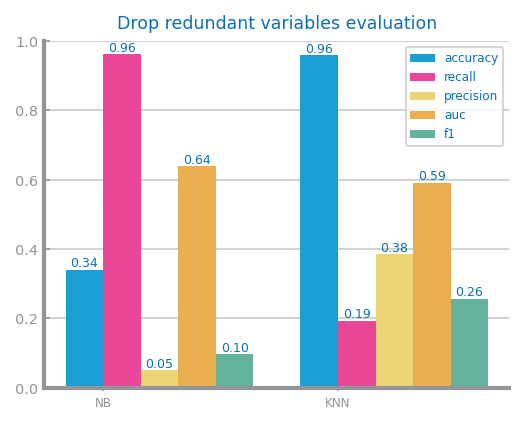

In [25]:
figure()
eval_redundant: dict[str, list] = evaluate_approach(train_cp, test_cp, target=target, metric="recall")
print(eval_redundant)
plot_multibar_chart(
    ["NB", "KNN"], eval_redundant, title="Drop redundant variables evaluation", percentage=True
)
savefig(f"{path_to_directory}/images/Set 2 - Drop redundant variables results.png", bbox_inches='tight')
show()

### Feature Engineering method evaluation
Assuming the best_eval comes from scaling which only has KNN

In [26]:
print(f"Continuing from {best_eval} with mean {best_mean}\n")

evaluations = {f"{best_eval}": best_eval_dict, "lowvar": eval_lowvar, "redundant": eval_redundant}

aux_best_eval = best_eval
best_mean = -float("inf")
best_mean_NB = -float("inf")
best_mean_KNN = -float("inf")
best_eval = None
best_eval_NB = None
best_eval_KNN = None

for eval_name, eval_dict in evaluations.items():
    if eval_name != "standard_scaler":
        # Calculate mean for NB and KNN using generator expressions
        mean_NB = sum(eval_dict[metric][0] for metric in ["accuracy", "recall", "precision", "auc", "f1"]) / 5
        mean_KNN = sum(eval_dict[metric][1] for metric in ["accuracy", "recall", "precision", "auc", "f1"]) / 5
        
        # Print means
        print(f"{eval_name}: Mean NB = {mean_NB}, Mean KNN = {mean_KNN}")

        # Update the best mean for NB
        if mean_NB > best_mean_NB:
            best_mean_NB = mean_NB
            best_eval_NB = eval_name

        # Update the best mean for KNN
        if mean_KNN > best_mean_KNN:
            best_mean_KNN = mean_KNN
            best_eval_KNN = eval_name
    else:
        mean_KNN = sum(eval_dict[metric][0] for metric in ["accuracy", "recall", "precision", "auc", "f1"]) / 5

        # Print means
        print(f"{eval_name}: Mean KNN = {mean_KNN}")

        # Update the best mean for KNN
        if mean_KNN > best_mean_KNN:
            best_mean_KNN = mean_KNN
            best_eval_KNN = eval_name

# Print the best mean scores
print(f"\nBest Mean NB: {best_mean_NB} from {best_eval_NB}")
print(f"Best Mean KNN: {best_mean_KNN} from {best_eval_KNN}")

if best_mean_NB > best_mean_KNN:
    best_mean = best_mean_NB
    best_eval = best_eval_NB
else:
    best_mean = best_mean_KNN
    best_eval = best_eval_KNN

# Print the best mean scores
print(f"\nContinuing with {best_eval} with mean {best_mean}")

# Determine the filename based on the best evaluations
if best_eval == f"{aux_best_eval}":
    filename = f"{path_to_directory}/datasets/{file_tag}_scaled_zscore.csv"
    best_eval_dict = best_eval_dict
elif best_eval == "lowvar":
    filename_train = f"{path_to_directory}/datasets/{file_tag}_train_lowvar.csv"
    filename_test = f"{path_to_directory}/datasets/{file_tag}_test_lowvar.csv"
    best_eval_dict = eval_lowvar
elif best_eval == "redundant":
    filename_train = f"{path_to_directory}/datasets/{file_tag}_train_redundant.csv"
    filename_test = f"{path_to_directory}/datasets/{file_tag}_test_redundant.csv"
    best_eval_dict = eval_redundant

Continuing from standard_scaler with mean 0.5260399990330378

standard_scaler: Mean KNN = 0.5260399990330378
lowvar: Mean NB = 0.5240576801463787, Mean KNN = 0.5317538909960575
redundant: Mean NB = 0.41711365739620787, Mean KNN = 0.4766374569483629

Best Mean NB: 0.5240576801463787 from lowvar
Best Mean KNN: 0.5317538909960575 from lowvar

Continuing with lowvar with mean 0.5317538909960575


# **Data Preparation (continuation)**
## **Balancing**
Assuming the best_eval comes from scaling which only has KNN

Minority class= 1 : 103
Majority class= 0 : 2758
Proportion: 0.04 : 1


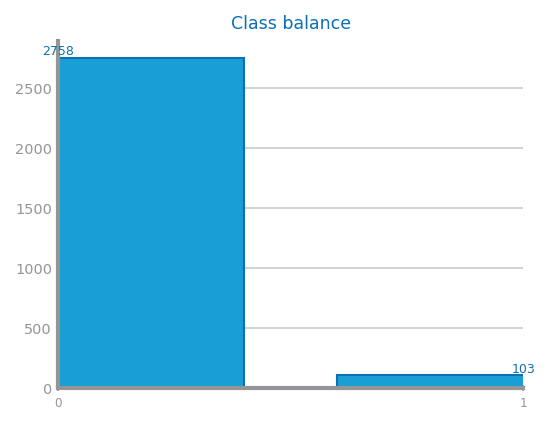

In [27]:
from pandas import read_csv, concat, DataFrame, Series
from matplotlib.pyplot import figure, show
from dslabs_functions import plot_bar_chart

original: DataFrame = read_csv(filepath_or_buffer=f"{filename_train}", sep=",", decimal=".")
test: DataFrame = read_csv(filepath_or_buffer=f"{filename_test}", sep=",", decimal=".")

target_count: Series = original[target].value_counts()
positive_class = target_count.idxmin()
negative_class = target_count.idxmax()

print("Minority class=", positive_class, ":", target_count[positive_class])
print("Majority class=", negative_class, ":", target_count[negative_class])
print(
    "Proportion:",
    round(target_count[positive_class] / target_count[negative_class], 2),
    ": 1",
)
values: dict[str, list] = {
    "Original": [target_count[positive_class], target_count[negative_class]]
}

figure()
plot_bar_chart(
    target_count.index.to_list(), target_count.to_list(), title="Class balance"
)
show()

In [28]:
df_positives: Series = original[original[target] == positive_class]
df_negatives: Series = original[original[target] == negative_class]

### Undersampling

In [29]:
df_neg_sample: DataFrame = DataFrame(df_negatives.sample(len(df_positives), random_state=42))
df_under: DataFrame = concat([df_positives, df_neg_sample], axis=0)
df_under.to_csv(f"{path_to_directory}/datasets/{file_tag}_undersampling.csv", index=False)

print("Minority class=", positive_class, ":", len(df_positives))
print("Majority class=", negative_class, ":", len(df_neg_sample))
print("Proportion:", round(len(df_positives) / len(df_neg_sample), 2), ": 1")

Minority class= 1 : 103
Majority class= 0 : 103
Proportion: 1.0 : 1


Methodology

{'accuracy': [0.7374301675977654, 0.8715083798882681], 'recall': [np.float64(0.9230769230769231), np.float64(0.8076923076923077)], 'precision': [np.float64(0.11428571428571428), np.float64(0.19444444444444445)], 'auc': [np.float64(0.8267558528428094), np.float64(0.8408026755852843)], 'f1': [np.float64(0.2033898305084746), np.float64(0.31343283582089554)]}


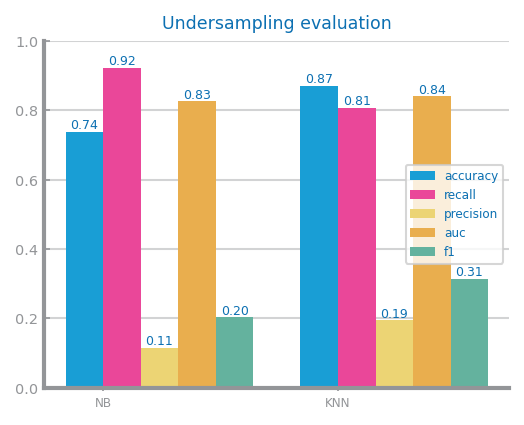

In [30]:
figure()
eval_undersampling: dict[str, list] = evaluate_approach(df_under, test, target=target, metric="recall")
print(eval_undersampling)
plot_multibar_chart(
    ["NB", "KNN"], eval_undersampling, title="Undersampling evaluation", percentage=True
)
savefig(f"{path_to_directory}/images/Set 2 - Undersampling results.png", bbox_inches='tight')
show()

Results are misleading!!
### Oversampling

In [31]:
df_pos_sample: DataFrame = DataFrame(
    df_positives.sample(len(df_negatives), replace=True, random_state=42)
)
df_over: DataFrame = concat([df_pos_sample, df_negatives], axis=0)
df_over.to_csv(f"{path_to_directory}/datasets/{file_tag}_oversampling.csv", index=False)

print("Minority class=", positive_class, ":", len(df_pos_sample))
print("Majority class=", negative_class, ":", len(df_negatives))
print("Proportion:", round(len(df_pos_sample) / len(df_negatives), 2), ": 1")

Minority class= 1 : 2758
Majority class= 0 : 2758
Proportion: 1.0 : 1


Methodology

{'accuracy': [0.5893854748603352, 0.8924581005586593], 'recall': [np.float64(0.9615384615384616), np.float64(0.8461538461538461)], 'precision': [np.float64(0.07861635220125786), np.float64(0.23157894736842105)], 'auc': [np.float64(0.7684503901895205), np.float64(0.8701783723522855)], 'f1': [np.float64(0.14534883720930233), np.float64(0.36363636363636365)]}


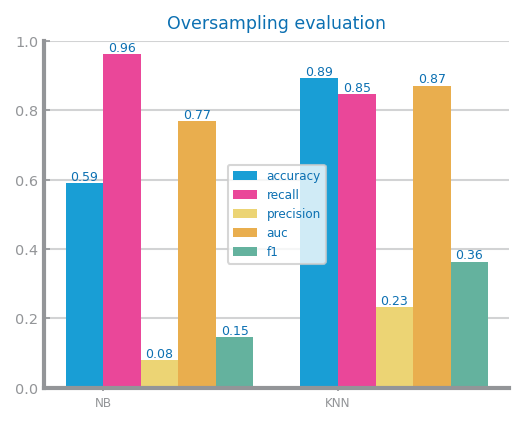

In [32]:
# Because CLASS column was removed
test: DataFrame = read_csv(filepath_or_buffer=f"{filename_test}", sep=",", decimal=".")

figure()
eval_oversampling: dict[str, list] = evaluate_approach(df_over, test, target=target, metric="recall")
print(eval_oversampling)
plot_multibar_chart(
    ["NB", "KNN"], eval_oversampling, title="Oversampling evaluation", percentage=True
)
savefig(f"{path_to_directory}/images/Set 2 - Oversampling results.png", bbox_inches='tight')
show()

### SMOTE

In [33]:
from numpy import ndarray
from pandas import Series
from imblearn.over_sampling import SMOTE

RANDOM_STATE = 42

smote: SMOTE = SMOTE(sampling_strategy="minority", random_state=RANDOM_STATE)
y = original.pop(target).values
X: ndarray = original.values
smote_X, smote_y = smote.fit_resample(X, y)
df_smote: DataFrame = concat([DataFrame(smote_X), DataFrame(smote_y)], axis=1)
df_smote.columns = list(original.columns) + [target]
df_smote.to_csv(f"{path_to_directory}/datasets/{file_tag}_smote.csv", index=False)

smote_target_count: Series = Series(smote_y).value_counts()
print("Minority class=", positive_class, ":", smote_target_count[positive_class])
print("Majority class=", negative_class, ":", smote_target_count[negative_class])
print(
    "Proportion:",
    round(smote_target_count[positive_class] / smote_target_count[negative_class], 2),
    ": 1",
)
print(df_smote.shape)

Minority class= 1 : 2758
Majority class= 0 : 2758
Proportion: 1.0 : 1
(5516, 78)


Methodology

{'accuracy': [0.659217877094972, 0.8687150837988827], 'recall': [np.float64(0.9615384615384616), np.float64(0.8846153846153846)], 'precision': [np.float64(0.09328358208955224), np.float64(0.20175438596491227)], 'auc': [np.float64(0.8046822742474917), np.float64(0.876365663322185)], 'f1': [np.float64(0.17006802721088435), np.float64(0.32857142857142857)]}


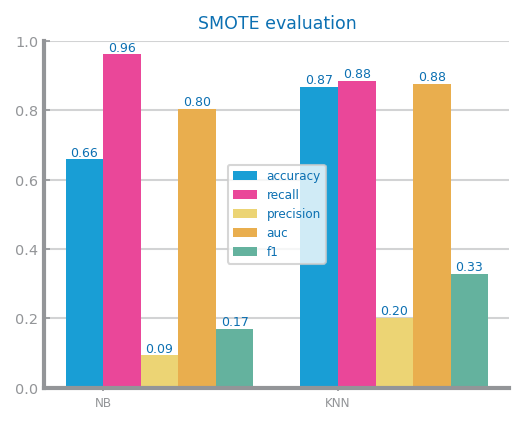

In [34]:
# Because CLASS column was removed
test: DataFrame = read_csv(filepath_or_buffer=f"{filename_test}", sep=",", decimal=".")

figure()
eval_smote: dict[str, list] = evaluate_approach(df_smote, test, target=target, metric="recall")
print(eval_smote)
plot_multibar_chart(
    ["NB", "KNN"], eval_smote, title="SMOTE evaluation", percentage=True
)
savefig(f"{path_to_directory}/images/Set 2 - SMOTE results.png", bbox_inches='tight')
show()

### Balancing method evaluation


In [35]:
print(f"Continuing from {best_eval} with mean {best_mean}\n")

evaluations = {f"{best_eval}": best_eval_dict, "undersampling": eval_undersampling, "oversampling": eval_oversampling, "smote": eval_smote}
# evaluations = {f"{best_eval}": best_eval_dict, "oversampling": eval_oversampling, "smote": eval_smote}

aux_best_eval = best_eval
best_mean = -float("inf")
best_mean_NB = -float("inf")
best_mean_KNN = -float("inf")
best_eval = None
best_eval_NB = None
best_eval_KNN = None

for eval_name, eval_dict in evaluations.items():
    # Calculate mean for NB and KNN using generator expressions
    mean_NB = sum(eval_dict[metric][0] for metric in ["accuracy", "recall", "precision", "auc", "f1"]) / 5
    mean_KNN = sum(eval_dict[metric][1] for metric in ["accuracy", "recall", "precision", "auc", "f1"]) / 5
    
    # Print means
    print(f"{eval_name}: Mean NB = {mean_NB}, Mean KNN = {mean_KNN}")

    # Update the best mean for NB
    if mean_NB > best_mean_NB:
        best_mean_NB = mean_NB
        best_eval_NB = eval_name

    # Update the best mean for KNN
    if mean_KNN > best_mean_KNN:
        best_mean_KNN = mean_KNN
        best_eval_KNN = eval_name

# Print the best mean scores
print(f"\nBest Mean NB: {best_mean_NB} from {best_eval_NB}")
print(f"Best Mean KNN: {best_mean_KNN} from {best_eval_KNN}")

if best_mean_NB > best_mean_KNN:
    best_mean = best_mean_NB
    best_eval = best_eval_NB
else:
    best_mean = best_mean_KNN
    best_eval = best_eval_KNN

# Print the best mean scores
print(f"\nContinuing with {best_eval} with mean {best_mean}")

# Determine the filename based on the best evaluations
if best_eval == f"{aux_best_eval}":
    filename_train = f"{path_to_directory}/datasets/{file_tag}_train_lowvar.csv"
    best_eval_dict = eval_lowvar
elif best_eval == "undersampling":
    filename_train = f"{path_to_directory}/datasets/{file_tag}_undersampling.csv"
elif best_eval == "oversampling":
    filename_train = f"{path_to_directory}/datasets/{file_tag}_oversampling.csv"
elif best_eval == "smote":
    filename_train = f"{path_to_directory}/datasets/{file_tag}_smote.csv"

filename_test = filename_test

Continuing from lowvar with mean 0.5317538909960575

lowvar: Mean NB = 0.5240576801463787, Mean KNN = 0.5317538909960575
undersampling: Mean NB = 0.5609876976623374, Mean KNN = 0.6055761286862401
oversampling: Mean NB = 0.5086679031997755, Mean KNN = 0.6408011260139151
smote: Mean NB = 0.5377580444362724, Mean KNN = 0.6320043892545587

Best Mean NB: 0.5609876976623374 from undersampling
Best Mean KNN: 0.6408011260139151 from oversampling

Continuing with oversampling with mean 0.6408011260139151
